### Environment

In [1]:
import sys
import os

# プロジェクトルートをsys.pathに追加
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH set to:", project_root)

PYTHONPATH set to: c:\Users\ndhaj\Desktop\TCI


### Load data

In [2]:
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")

from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.rng_utils import normal, get_rng

ptycho = Ptycho()
obj = load_data_image("cameraman.png") * np().exp(1j * np().pi * load_data_image("eagle.png"))
rng = get_rng(seed = 50)

from PtychoEP.utils.ptycho.aperture_utils import circular_aperture
probe = circular_aperture(size = 64, r = 0.48)

ptycho.set_object(obj)
ptycho.set_probe(probe)

### Scan position

In [3]:
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions

positions = generate_spiral_scan_positions(image_size=512, probe_size=64, step = 22, num_points=400)
print(f"Generated {len(positions)} scan positions")

Generated 132 scan positions


### forward calculation

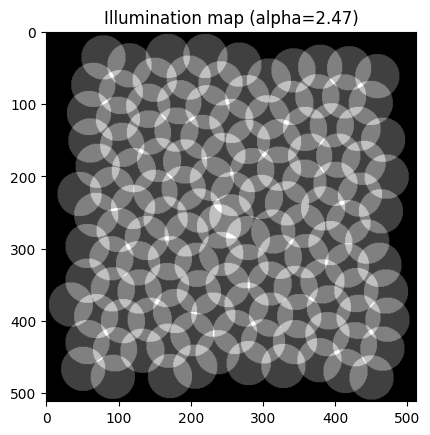

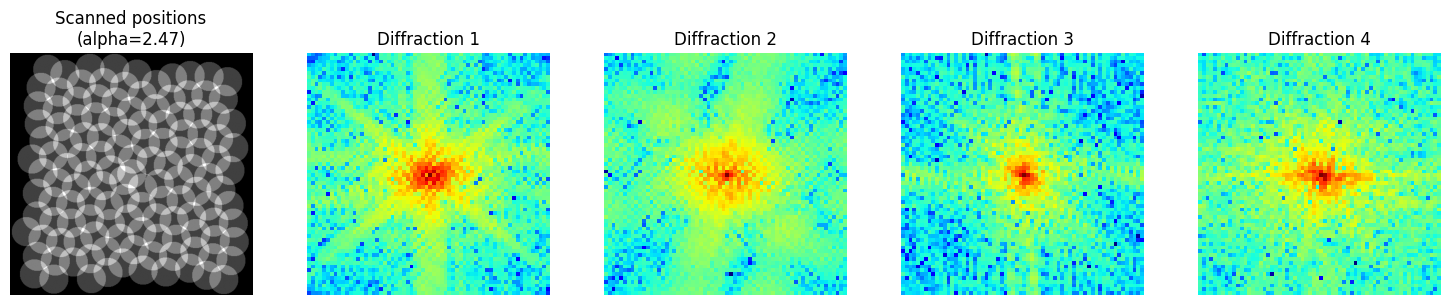

In [4]:
ptycho.forward_and_set_diffraction(positions)

from PtychoEP.utils.ptycho.visualize import compute_illumination, show_scan_and_diffs
scan_img, alpha = compute_illumination(ptycho)

import matplotlib.pyplot as plt
plt.imshow(scan_img, cmap="gray")
plt.title(f"Illumination map (alpha={alpha:.2f})")
plt.show()

fig = show_scan_and_diffs(ptycho, num_patterns=4, log_scale=True)

In [5]:
from PtychoEP.utils.ptycho.noise import GaussianNoise, PoissonNoise

GaussianNoise(var=1e-5) @ ptycho
print("Gaussian noise SNR [dB]:", ptycho.noise_stats["snr_mean_db"])

Gaussian noise SNR [dB]: 45.457275390625


In [6]:
from PtychoEP.utils.engines.pie import PIE


# 誤差ログを記録するためのリストとコールバック
errors = []

def callback(iter_idx, err, obj_est):
    errors.append(err)
    if iter_idx % 10 == 0:
        print(f"Iteration {iter_idx}: Error = {err:.4e}")

# PIEインスタンス生成（alphaは0.1程度から試すのが無難）
pie = PIE(ptycho, alpha=0.1, callback = callback)

In [7]:
obj_est = pie.run(n_iter=100)

Iteration 0: Error = 4.5293e-01
Iteration 10: Error = 4.4283e-03
Iteration 20: Error = 2.8204e-03
Iteration 30: Error = 2.1535e-03
Iteration 40: Error = 1.8012e-03
Iteration 50: Error = 1.5606e-03
Iteration 60: Error = 1.3625e-03
Iteration 70: Error = 1.1825e-03
Iteration 80: Error = 1.0324e-03
Iteration 90: Error = 9.1047e-04


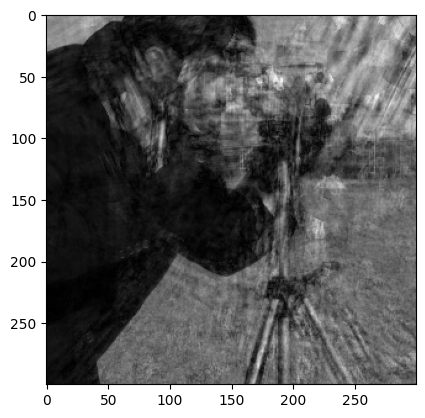

In [8]:
plt.imshow(np().abs(obj_est[100:400,100:400]), cmap = "gray")

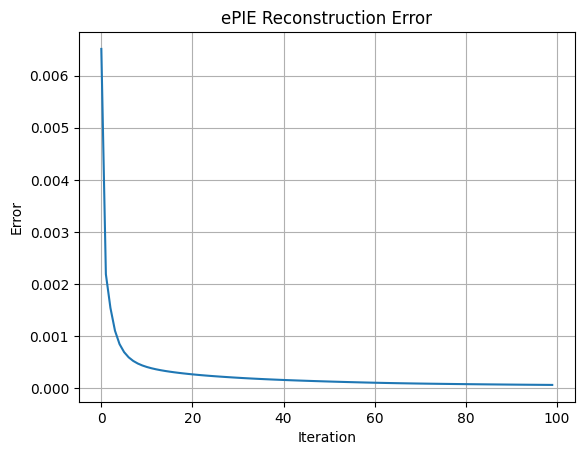

In [9]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.epie import ePIE
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- ePIE 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

epie = ePIE(ptycho, alpha=0.1, beta=0.1, callback=callback)
obj_est, prb_est = epie.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("ePIE Reconstruction Error")
plt.grid()
plt.show()

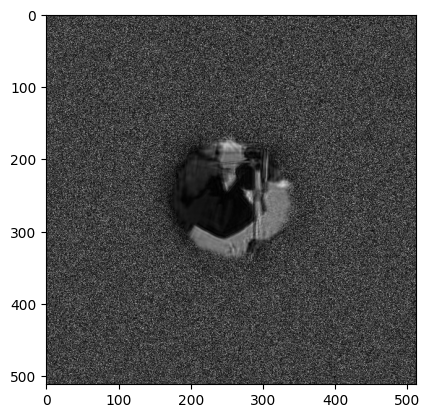

In [10]:
plt.imshow(np().abs(obj_est), cmap = "gray")

In [11]:
%prun epie.run(n_iter=100)

         2040304 function calls in 15.498 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    80000    5.809    0.000    5.847    0.000 _pocketfft.py:51(_raw_fft)
    20000    3.957    0.000    4.163    0.000 epie.py:9(_update_object)
    20000    1.844    0.000    2.037    0.000 epie.py:17(_update_probe)
    20000    1.335    0.000    8.079    0.000 projector.py:3(Fourier_projector)
        1    1.220    1.220   15.498   15.498 epie.py:26(run)
    60000    0.233    0.000    0.233    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    40000    0.155    0.000    0.155    0.000 {method 'conj' of 'numpy.ndarray' objects}
    40000    0.134    0.000    0.364    0.000 _pocketfft.py:698(_cook_nd_args)
    40000    0.133    0.000    6.418    0.000 _pocketfft.py:735(_raw_fftnd)
    20000    0.100    0.000    0.267    0.000 _methods.py:118(_mean)
    40000    0.071    0.000    0.129    0.000 fromnumeric.py:41(_wrapit)
    40000    

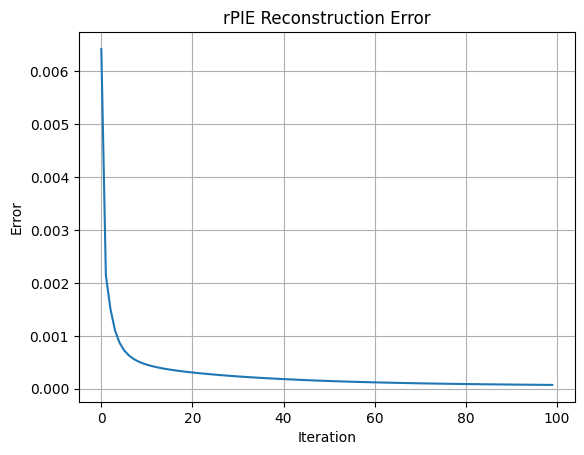

In [12]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.rpie import rPIE
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- rPIE 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

rpie = rPIE(ptycho, alpha=0.1, beta=0.1, callback=callback)
obj_est, prb_est = rpie.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("rPIE Reconstruction Error")
plt.grid()
plt.show()

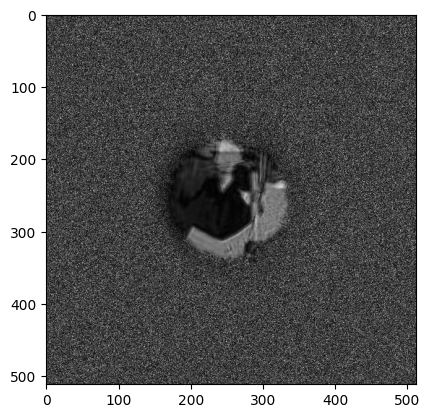

In [13]:
plt.imshow(np().abs(obj_est), cmap = "gray")

In [14]:
%prun rpie.run(n_iter=100)

         2040304 function calls in 16.104 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    80000    5.906    0.000    5.944    0.000 _pocketfft.py:51(_raw_fft)
    20000    3.945    0.000    4.142    0.000 rpie.py:9(_update_object)
    20000    2.223    0.000    2.450    0.000 rpie.py:18(_update_probe)
    20000    1.334    0.000    8.197    0.000 projector.py:3(Fourier_projector)
        1    1.315    1.315   16.104   16.104 rpie.py:28(run)
    60000    0.228    0.000    0.228    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    40000    0.186    0.000    0.186    0.000 {method 'conj' of 'numpy.ndarray' objects}
    40000    0.147    0.000    6.533    0.000 _pocketfft.py:735(_raw_fftnd)
    40000    0.136    0.000    0.369    0.000 _pocketfft.py:698(_cook_nd_args)
    20000    0.103    0.000    0.270    0.000 _methods.py:118(_mean)
    40000    0.071    0.000    0.131    0.000 fromnumeric.py:41(_wrapit)
    40000    

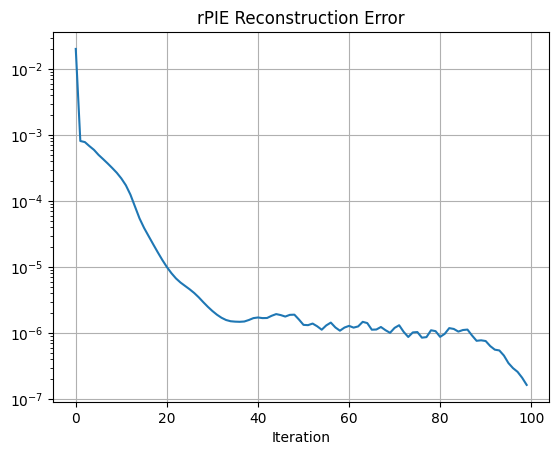

In [3]:
# バックエンド設定
from PtychoEP.utils.backend import set_backend, np
set_backend("numpy")  # まずはCPUで試す

# 必要モジュールのインポート
from PtychoEP.utils.ptycho.core import Ptycho
from PtychoEP.utils.io_utils import load_data_image
from PtychoEP.utils.ptycho.scan_utils import generate_spiral_scan_positions
from PtychoEP.utils.engines.difference_map import DifferenceMap
from PtychoEP.utils.ptycho.visualize import compute_illumination
import matplotlib.pyplot as plt

# --- データ準備 ---
ptycho = Ptycho()

# オブジェクトの設定 (位相オブジェクト)
obj_amp = load_data_image("cameraman.png")
obj_phase = load_data_image("eagle.png")
obj = np().asarray(obj_amp * np().exp(1j * np().pi * obj_phase), dtype = np().complex64)
ptycho.set_object(obj)

# プローブ設定 (真値と初期値を別々に管理)
probe_true = np().asarray(load_data_image("probe.png"), dtype = np().complex64)              # 真のプローブ
probe_init = np().asarray(load_data_image("probe_init.png"), dtype = np().complex64)          # 初期推定用プローブ

# 真値でforward計算
ptycho.set_probe(probe_true)
positions = generate_spiral_scan_positions(image_size=512, probe_size=128, num_points=200, step = 5)
ptycho.forward_and_set_diffraction(positions)

# 推定用にプローブを初期値にリセット
ptycho.set_probe(probe_init)

# --- DM 実行 ---
errors = []
def callback(iter_idx, err, obj_est):
    errors.append(err)

dm = DifferenceMap(ptycho, callback=callback)
obj_est, prb_est = dm.run(n_iter=100)

# --- 誤差推移の可視化 ---
plt.plot(errors)
plt.xlabel("Iteration")
plt.yscale("log")
plt.title("rPIE Reconstruction Error")
plt.grid()
plt.show()

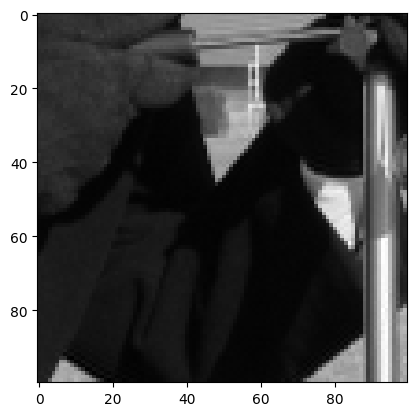

In [27]:
plt.imshow(np().abs(obj_est[200:300, 200:300]).get(), cmap = "gray")